In [1]:
!pip install networkx
!pip install pyod
!pip install torch-geometric

In [2]:
import networkx
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from pyod.models.lof import LOF
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy.io import loadmat
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from torch.optim import Adam

# **Exercise 1:** OddBall

**1.** In the first exercise you will implement a version of the OddBall algorithm discussed in the course. You will first load the dataset from
the ca-AstroPh.txt file (each line contains an edge of the graph) and
build the corresponding undirected graph using **networkx.Graph**. Each
appearance of an edge in the dataset will increase the weight of the
edge by one (you can store the weight for each edge with a key using
**G[node1][node2]['weight'] = weight**).

In [89]:
# download the dataset
!wget https://snap.stanford.edu/data/ca-AstroPh.txt.gz

--2025-01-20 09:06:07--  https://snap.stanford.edu/data/ca-AstroPh.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453950 (1.4M) [application/x-gzip]
Saving to: ‘ca-AstroPh.txt.gz.1’

ca-AstroPh.txt.gz.1 100%[===================>]   1.39M   547KB/s    in 2.6s    

2025-01-20 09:06:10 (547 KB/s) - ‘ca-AstroPh.txt.gz.1’ saved [1453950/1453950]



In [90]:
# define the Graph object and read the edges from the .txt file
graph = networkx.Graph()
max_edges = 1500

def process_edge(edge: str):
  [node_from, node_to] = edge.decode("utf-8").split()
  node_from, node_to = int(node_from), int(node_to)
  return (node_from, node_to)

with gzip.open('ca-AstroPh.txt.gz', 'rb') as f:
  astro_ph = f.readlines()[4:max_edges]
  astro_ph = [process_edge(line) for line in astro_ph]
  edge_counts = Counter(astro_ph)

  for edge, count in edge_counts.items():
    graph.add_edge(edge[0], edge[1], weight=count)

**2.** Extract the four features from the egonet (subgraph consisting of all neighbours) corresponding to each node:

• $N_{i}$ - number of neighbors

• $E_{i}$ - number of edges in $egonet_{i}$

• $W_{i}$ - total weight of $egonet_{i}$

• $λ_{w}, i$ - principal eigenvalue of the weighted adjacency matrix of $egonet_
{i}$

Store the features in the Graph object using **nx.set_node_attributes**.

In [91]:
def egonet_attributes(graph: networkx.Graph, node: int) -> dict | None:
  if node not in graph:
    return

  egonet = networkx.ego_graph(graph, node)

  neighbours = egonet.number_of_nodes()
  edges = egonet.number_of_edges()
  weight = np.sum([data['weight'] for u, v, data in egonet.edges(data=True)])
  eigenvalue = max(networkx.adjacency_spectrum(egonet))

  return {
    node: {
      "neighbours": neighbours,
      "edges": edges,
      "weight": weight,
      "eigenvalue": eigenvalue
    }}

def set_egonet_attributes(graph: networkx.Graph) -> None:
  egonet_attributes_dict = {}

  for node in graph.nodes:
    attributes = egonet_attributes(graph, node)
    egonet_attributes_dict.update(attributes)

  networkx.set_node_attributes(graph, egonet_attributes_dict)

In [92]:
set_egonet_attributes(graph)

**3.** Compute the anomaly score for each node by fitting a **LinearRegression** model (from sklearn.linear model) with the logarithmic scale of the
2 features ($E_{i}$ and $N_{i}$ - which should detect near-cliques and stars). The anomaly score will be:

$$score_{i} = \frac{max(y_{i}, Cx^{θ}_{i})}{min(y_{i}, Cx^{θ}_{i})} log(|y_{i} - Cx^{θ}_{i}| + 1)$$

given the power-law equation $y = Cx^{θ}$.

In [93]:
# extract the number of neighbours as a numpy array and log scale
graph_neighbours = networkx.get_node_attributes(graph, 'neighbours')
graph_neighbours = np.array(list(graph_neighbours.values())).reshape(-1, 1)
graph_neighbours_log = np.log(graph_neighbours)

# extract the number of edges as a numpy array and log scale
graph_edges = networkx.get_node_attributes(graph, 'edges')
graph_edges = np.array(list(graph_edges.values())).reshape(-1, 1)
graph_edges_log = np.log(graph_edges)

In [94]:
# train a linear regression model to predict the number of edges
# based on the total number of nodes in a egonet, then compute
# the anomaly score for each data point

graph_reg = LinearRegression()
graph_reg.fit(graph_neighbours_log, graph_edges_log)

graph_edges_preds = graph_reg.predict(graph_neighbours)
graph_edges_preds = np.exp(graph_edges_preds)

odd_ball_anomaly_scores = np.maximum(graph_edges, graph_edges_preds) / np.minimum(graph_edges, graph_edges_preds)  * np.log(np.abs(graph_edges - graph_edges_preds) + 1)
odd_ball_anomaly_scores = odd_ball_anomaly_scores.squeeze()

**4.** Sort the scores of the nodes in descending order and draw the graph using
*nx.draw()*. Using the node color parameter for the specified function,
draw the nodes corresponding to the biggest 10 scores with a different
color. Use just the first 1500 rows from the file when generating the
graph.

In [100]:
# sort the nodes by anomaly scores descending, and extract their corresponding
# index in the initial list of nodes
odd_ball_anomaly_scores_idxs = np.argsort(odd_ball_anomaly_scores)[::-1]
graph_positions = networkx.spring_layout(graph)
# get the nodes that have anomaly score among the best 10
top_anomaly_nodes = np.array(graph.nodes)[odd_ball_anomaly_scores_idxs[:10]]

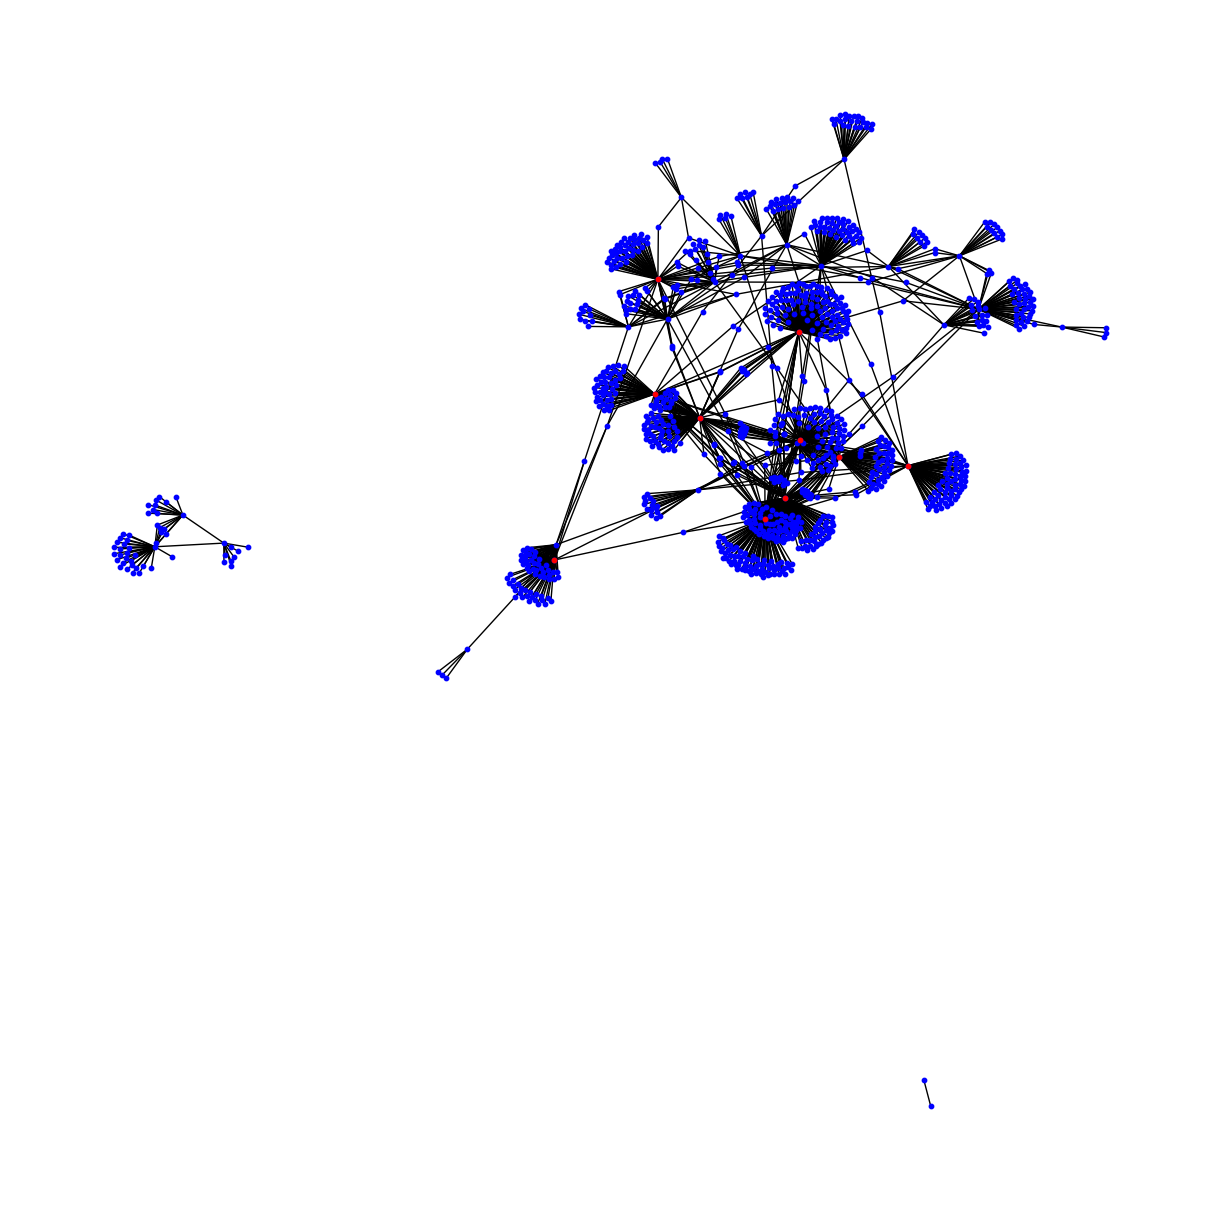

In [101]:
plt.figure(figsize=(12, 12))
networkx.draw(graph, graph_positions, node_color="blue", node_size=10, with_labels=False)
networkx.draw_networkx_nodes(graph, graph_positions, nodelist=top_anomaly_nodes, node_color="red", node_size=10)
plt.show()

Modify the anomaly score as the sum of the normalized score that was
computed earlier and the score obtained by **LOF** (for the pair of $E_{i}$ and
$N_{i}$ features) and draw again the graph using a different color for the nodes
corresponding to the biggest 10 scores.

In [97]:
# fit LOF and compute the LOF anomaly scores
lof_regressor = LOF()
lof_regressor.fit(graph_neighbours, graph_edges)
lof_anomaly_scores = lof_regressor.predict(graph_neighbours)

# compute the anomaly score by summing normalized odd ball scores and lof scores
ensemble_scores = (odd_ball_anomaly_scores - np.mean(odd_ball_anomaly_scores)) / np.std(odd_ball_anomaly_scores) + lof_anomaly_scores

/usr/local/lib/python3.11/dist-packages/pyod/models/base.py:554: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


In [98]:
# sort the nodes by anomaly scores descending, and extract their corresponding
# index in the initial list of nodes
ensemble_scores_idxs = np.argsort(ensemble_scores)[::-1]

# get the nodes that have anomaly score among the best 10
top_ensemble_anomaly_nodes = np.array(graph.nodes)[ensemble_scores_idxs[:10]]

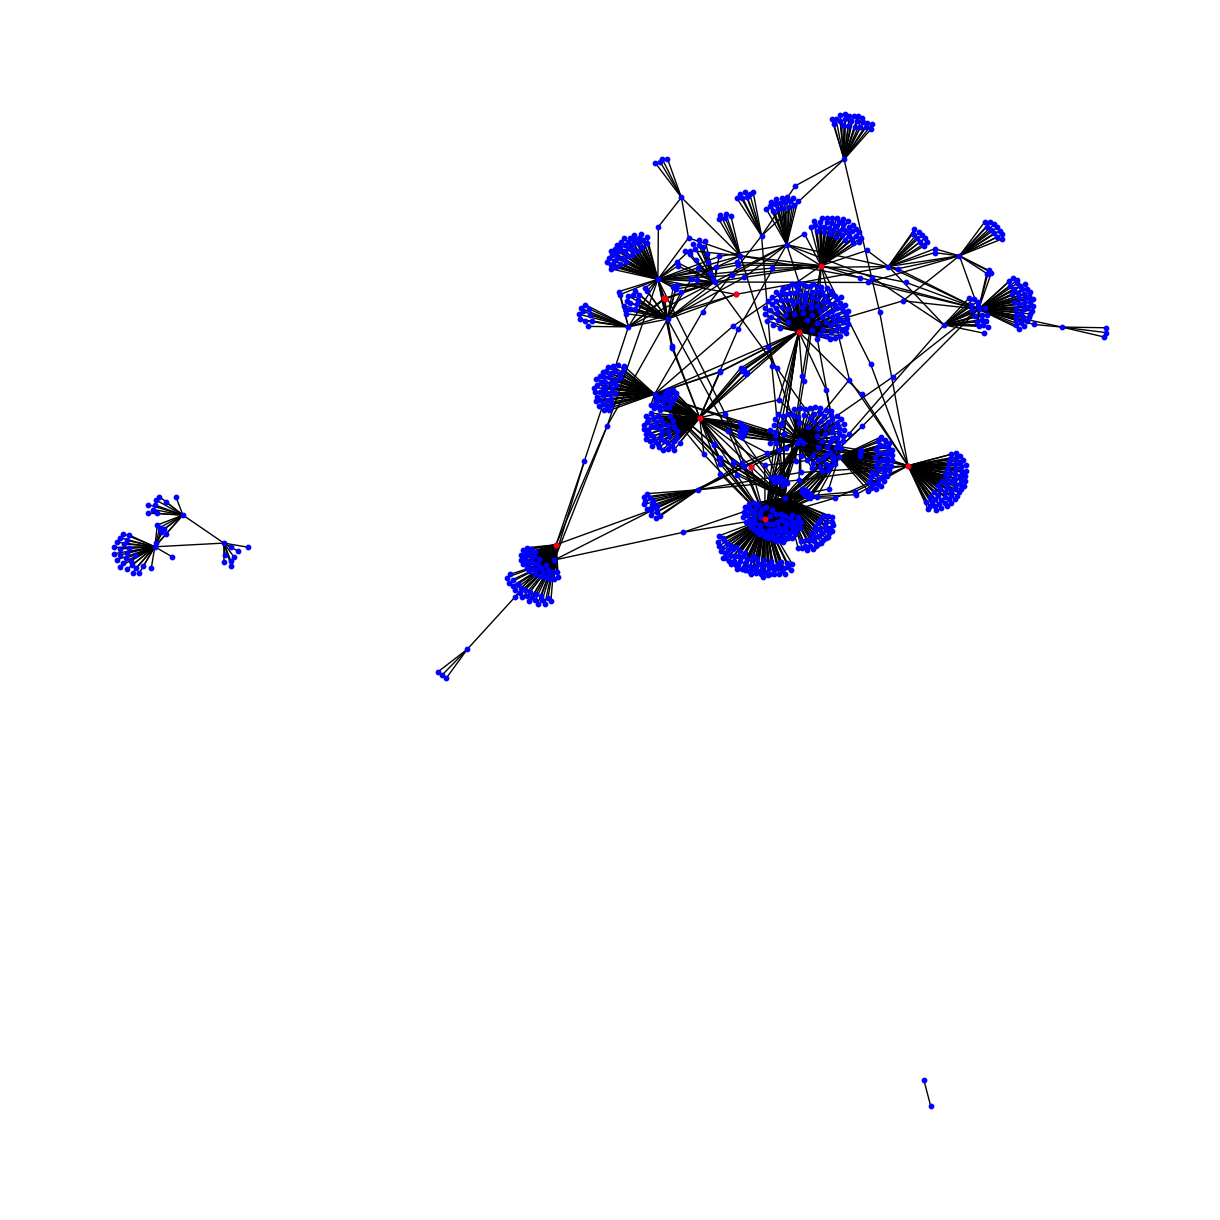

In [102]:
plt.figure(figsize=(12, 12))
networkx.draw(graph, graph_positions, node_color="blue", node_size=10, with_labels=False)
networkx.draw_networkx_nodes(graph, graph_positions, nodelist=top_ensemble_anomaly_nodes, node_color="red", node_size=10)
plt.show()

# **Exercise 2:** Graph anomalies generation

**1.** In this exercise we will generate some types of graph anomalies using networkx package. You will first generate a regular graph with 100 nodes where each one will have a degree 3 using **networkx.random_regular_graph()**.
You will merge it with another graph that will contain 10 cliques with 20
nodes each. This one will be generated using **networkx.connected_caveman_graph()**. Both will be merged using **networkx.union()** and some random edges
will be added in order to build a connected graph. Draw the resulted
graph. Use the model developed in the first exercise to detect the first 10
nodes that are most probably part of a clique in the final merged graph
(using $E_{i}$ and $N_{i}$) and draw them using a different color.

In [103]:
regular_graph = networkx.random_regular_graph(3, 100)
caveman_graph = networkx.connected_caveman_graph(10, 20)
anomalous_graph = networkx.union(regular_graph, caveman_graph, rename=("R", "C"))

In [110]:
# add 10 random edges between the regular graph and the cavemen graph
# to form a connected graph
random_edges_size = 10

for i in range(random_edges_size):
  regular_node = np.random.choice(list(regular_graph.nodes))
  regular_node = f"R{regular_node}"

  cavemen_node = np.random.choice(list(caveman_graph.nodes))
  cavemen_node = f"C{cavemen_node}"

  anomalous_graph.add_edge(regular_node, cavemen_node)

In [115]:
# compute egonets for each node
networkx.set_edge_attributes(anomalous_graph, 1, "weight")
set_egonet_attributes(anomalous_graph)

In [116]:
# extract the number of neighbours as a numpy array and log scale
a_graph_neighbours = networkx.get_node_attributes(anomalous_graph, 'neighbours')
a_graph_neighbours = np.array(list(a_graph_neighbours.values())).reshape(-1, 1)
a_graph_neighbours_log = np.log(a_graph_neighbours)

# extract the number of edges as a numpy array and log scale
a_graph_edges = networkx.get_node_attributes(anomalous_graph, 'edges')
a_graph_edges = np.array(list(a_graph_edges.values())).reshape(-1, 1)
a_graph_edges_log = np.log(a_graph_edges)

In [117]:
# train a linear regression model to predict the number of edges
# based on the total number of nodes in a egonet, then compute
# the anomaly score for each data point

a_graph_reg = LinearRegression()
a_graph_reg.fit(a_graph_neighbours_log, a_graph_edges_log)

a_graph_edges_preds = a_graph_reg.predict(a_graph_neighbours)
a_graph_edges_preds = np.exp(a_graph_edges_preds)

odd_ball_anomaly_scores = np.maximum(a_graph_edges, a_graph_edges_preds) / np.minimum(a_graph_edges, a_graph_edges_preds)  * np.log(np.abs(a_graph_edges - a_graph_edges_preds) + 1)
odd_ball_anomaly_scores = odd_ball_anomaly_scores.squeeze()

In [118]:
# fit LOF and compute the LOF anomaly scores
lof_regressor = LOF()
lof_regressor.fit(a_graph_neighbours, a_graph_edges)
lof_anomaly_scores = lof_regressor.predict(a_graph_neighbours)

# compute the anomaly score by summing normalized odd ball scores and lof scores
ensemble_scores = (odd_ball_anomaly_scores - np.mean(odd_ball_anomaly_scores)) / np.std(odd_ball_anomaly_scores) + lof_anomaly_scores

/usr/local/lib/python3.11/dist-packages/pyod/models/base.py:554: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


In [119]:
# sort the nodes by anomaly scores descending, and extract their corresponding
# index in the initial list of nodes
ensemble_scores_idxs = np.argsort(ensemble_scores)[::-1]
anomalous_graph_positions = networkx.spring_layout(anomalous_graph)

# get the nodes that have anomaly score among the best 10
top_ensemble_anomaly_nodes = np.array(anomalous_graph.nodes)[ensemble_scores_idxs[:10]]

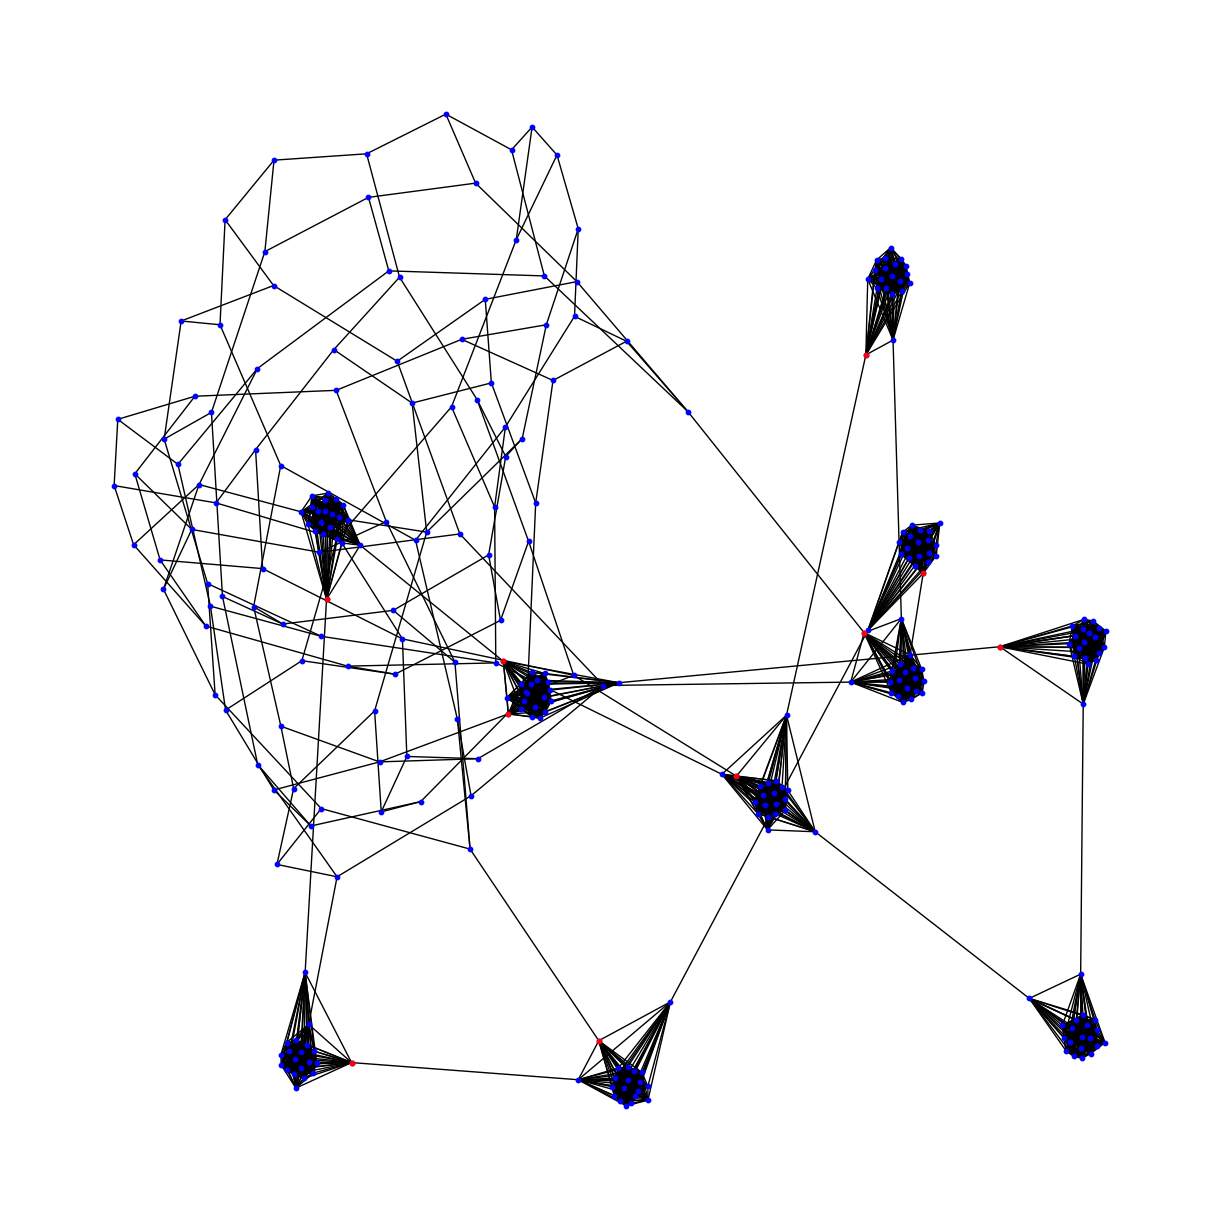

In [120]:
plt.figure(figsize=(12, 12))
networkx.draw(anomalous_graph, anomalous_graph_positions, node_color="blue", node_size=10, with_labels=False)
networkx.draw_networkx_nodes(anomalous_graph, anomalous_graph_positions, nodelist=top_ensemble_anomaly_nodes, node_color="red", node_size=10)
plt.show()

**2.** Here you will generate some **HeavyVicinity** anomalies. You will generate a regular graph with 100 nodes where each one will have a degree 3 and another one that has 100 nodes and each member node has degree 5 (using **networkx.random_regular_graph**). You will merge them using **networkx.union()** and then you will assign weight 1 for each edge using **G.add_edge(edge[0], edge[1], weight=1)** while iterating over all the edges. You will pick 2 random nodes and you will add 10 to the weights of all the edges from their egonets (using **G[node1][node2][”weight”]** += 10). Then you will use the same model to draw with a different color the 4 nodes that have the greatest score (using Wi and Ei - which should detect the heavy vicinities).

In [160]:
reg_graph_1 = networkx.random_regular_graph(3, 100)
reg_graph_2 = networkx.random_regular_graph(5, 100)
heavy_vicinity_graph = networkx.union(reg_graph_1, reg_graph_2, rename=("RO", "RT"))

In [161]:
# add 10 random edges between the regular graphs
random_edges_size = 10

for i in range(random_edges_size):
  reg_1_node = np.random.choice(list(reg_graph_1.nodes))
  reg_1_node = f"RO{reg_1_node}"

  reg_2_node = np.random.choice(list(reg_graph_2.nodes))
  reg_2_node = f"RT{reg_2_node}"

  heavy_vicinity_graph.add_edge(reg_1_node, reg_2_node)

In [162]:
# assign weight 1 to all edges
networkx.set_edge_attributes(heavy_vicinity_graph, 1, "weight")

In [163]:
# select two random nodes from the combined graph
# and add 10 weight to each node in their egonet
reg_nodes_high_weight = np.random.choice(list(heavy_vicinity_graph.nodes), size=2, replace=False)

for node in reg_nodes_high_weight:
  egonet = networkx.ego_graph(heavy_vicinity_graph, node)
  for neighbour in egonet.nodes:
    if node != neighbour:
      heavy_vicinity_graph[node][neighbour]["weight"] += 10

In [164]:
# compute the egonet attributes
set_egonet_attributes(heavy_vicinity_graph)

Extract the $W_{i}$ and $E_{i}$ from each node's egonet.

In [165]:
# extract the number of neighbours as a numpy array and log scale
heavy_vicinity_graph_neighbours = networkx.get_node_attributes(heavy_vicinity_graph, 'weight')
heavy_vicinity_graph_neighbours = np.array(list(heavy_vicinity_graph_neighbours.values())).reshape(-1, 1)
heavy_vicinity_graph_neighbours_log = np.log(heavy_vicinity_graph_neighbours)

# extract the number of edges as a numpy array and log scale
heavy_vicinity_graph_edges = networkx.get_node_attributes(heavy_vicinity_graph, 'edges')
heavy_vicinity_graph_edges = np.array(list(heavy_vicinity_graph_edges.values())).reshape(-1, 1)
heavy_vicinity_graph_edges_log = np.log(heavy_vicinity_graph_edges)

Fit *LinearRegression* on $W_{i}$ and $E_{i}$.

In [166]:
# train a linear regression model to predict the number of edges
# based on the total number of nodes in a egonet, then compute
# the anomaly score for each data point
heavy_vicinity_graph_reg = LinearRegression()
heavy_vicinity_graph_reg.fit(heavy_vicinity_graph_neighbours_log, heavy_vicinity_graph_edges_log)

heavy_vicinity_graph_edges_preds = heavy_vicinity_graph_reg.predict(heavy_vicinity_graph_neighbours)
heavy_vicinity_graph_edges_preds = np.exp(heavy_vicinity_graph_edges_preds)

odd_ball_anomaly_scores = np.maximum(heavy_vicinity_graph_edges, heavy_vicinity_graph_edges_preds) / np.minimum(heavy_vicinity_graph_edges, heavy_vicinity_graph_edges_preds)  * np.log(np.abs(heavy_vicinity_graph_edges - heavy_vicinity_graph_edges_preds) + 1)
odd_ball_anomaly_scores = odd_ball_anomaly_scores.squeeze()

In [167]:
# fit LOF and compute the LOF anomaly scores
lof_regressor = LOF()
lof_regressor.fit(heavy_vicinity_graph_neighbours, heavy_vicinity_graph_edges)
lof_anomaly_scores = lof_regressor.predict(heavy_vicinity_graph_neighbours)

# compute the anomaly score by summing normalized odd ball scores and lof scores
ensemble_scores = (odd_ball_anomaly_scores - np.mean(odd_ball_anomaly_scores)) / np.std(odd_ball_anomaly_scores) + lof_anomaly_scores

/usr/local/lib/python3.11/dist-packages/pyod/models/base.py:554: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


In [172]:
# sort the nodes by anomaly scores descending, and extract their corresponding
# index in the initial list of nodes
ensemble_scores_idxs = np.argsort(ensemble_scores)[::-1]
heavy_vicinity_graph_positions = networkx.spring_layout(heavy_vicinity_graph)

# get the nodes that have anomaly score among the best 10
top_ensemble_anomaly_nodes = np.array(heavy_vicinity_graph.nodes)[ensemble_scores_idxs[:4]]

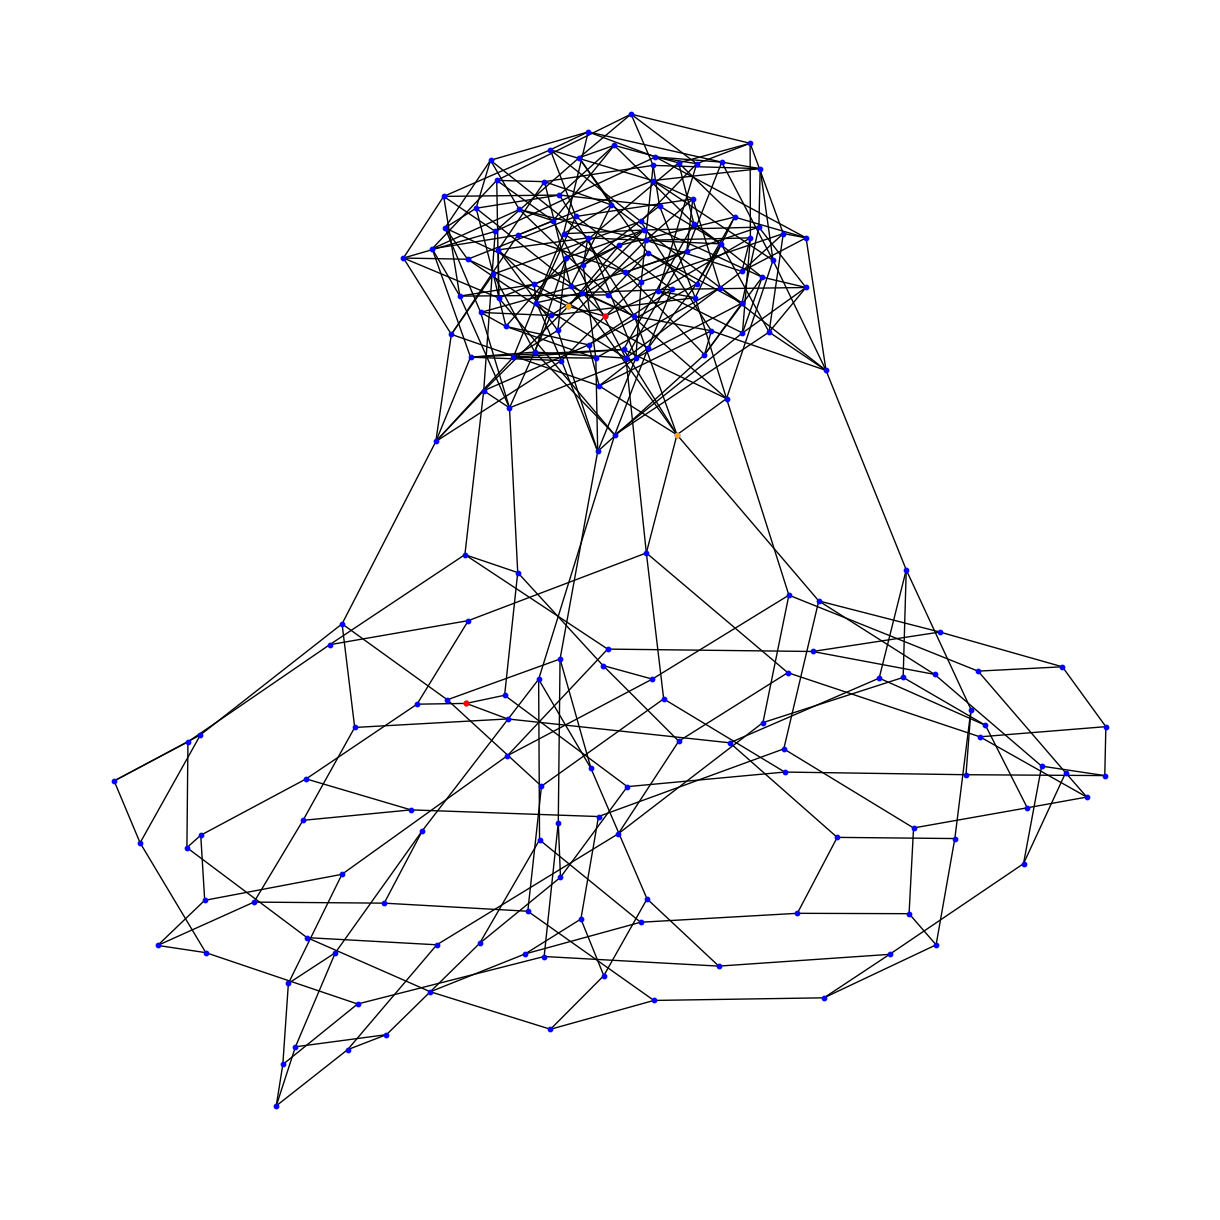

In [173]:
plt.figure(figsize=(12, 12))
networkx.draw(heavy_vicinity_graph, heavy_vicinity_graph_positions, node_color="blue", node_size=10, with_labels=False)
networkx.draw_networkx_nodes(heavy_vicinity_graph, heavy_vicinity_graph_positions, nodelist=top_ensemble_anomaly_nodes, node_color="orange", node_size=10)
networkx.draw_networkx_nodes(heavy_vicinity_graph, heavy_vicinity_graph_positions, nodelist=reg_nodes_high_weight, node_color="red", node_size=10)
plt.show()

# **Exercise 3:** Graph Autoencoder

 In this exercise we will design a *Graph Autoencoder (GAE)* capable of
ranking anomalous nodes from an Attributed Graph (based on reconstruction error). For this, we will use **GCNConv** layers from **torch geometric.nn**.
The autoencoder will contain an Encoder that will encode both structure
information and node attributes, and two separate decoders. One will
reconstruct the attributes of the nodes from the latent representations of
the encoder and the other one will reconstruct the adjacency matrix (from
the same latent representations).

**1.** Load the ACM dataset (from ACM.mat file) and extract the attributes of
the nodes (*”Attributes”* key), the adjacency matrix (*”Network”* key) and
the labels of the nodes (*”Label”* key). You can convert the adjacency matrix from the sparse matrix format in edge list using *from_scipy_sparse_matrix()*
function from torch *geometric.utils.convert*.


In [5]:
acm_dataset = loadmat("/content/ACM.mat")
acm_network, _ = from_scipy_sparse_matrix(acm_dataset["Network"])
acm_attributes = torch.tensor(acm_dataset["Attributes"].todense(), dtype=torch.float32)

**2.** Design a graph autoencoder that subclasses the **torch.nn.Model** class. This will contain the encoder and the two decoder sub-models (these will also subclass **torch.nn.Model**). The encoder will contain:
- 1 **GCNConv** layer which encodes the input samples in samples of
size 128, followed by a relu activation
- 1 **GCNConv** layer which encodes the output of the previous layer
to 64-sized samples, followed by a relu activation

The attribute decoder will consist of the same 2 layers (but with reversed input/output size).

The structure decoder will contain one GCNConv layer (that will keep
the dimension of the latent representations), followed by a relu activation.

Then, the structure decoder will return the **Z @ Z.T** product (where Z is the output of the relu activation) in order to match the size of the adjacency matrix.

You have to define the forward method for each of the 3 models (in order
to define the computations performed when data is passed through the
network).


In [6]:
class Encoder(nn.Module):
    def __init__(self, in_size: int, latent_size: int):
        super(Encoder, self).__init__()
        self.gcn_conv_1 = GCNConv(in_size, 128)
        self.gcn_conv_2 = GCNConv(128, 64)
        self.gcn_conv_3 = GCNConv(64, latent_size)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.gcn_conv_1(x, edge_index))
        x = torch.relu(self.gcn_conv_2(x, edge_index))
        x = self.gcn_conv_3(x, edge_index)

        return x

In [7]:
class AttributeDecoder(nn.Module):
    def __init__(self, in_size: int, latent_size: int):
        super(AttributeDecoder, self).__init__()
        self.gcn_conv_1 = GCNConv(latent_size, 64)
        self.gcn_conv_2 = GCNConv(64, 128)
        self.gcn_conv_3 = GCNConv(128, in_size)

    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        z = torch.relu(self.gcn_conv_1(z, edge_index))
        z = torch.relu(self.gcn_conv_2(z, edge_index))
        z = self.gcn_conv_3(z, edge_index)

        return z

In [8]:
class StructureDecoder(nn.Module):
    def __init__(self, latent_size: int):
        super(StructureDecoder, self).__init__()
        self.gcn_conv_1 = GCNConv(latent_size, latent_size)

    def forward(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        z = torch.relu(self.gcn_conv_1(z, edge_index))
        z = z @ z.T

        return z

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, in_size: int, latent_size: int):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_size, latent_size)
        self.attr_decoder = AttributeDecoder(in_size, latent_size)
        self.struct_decoder = StructureDecoder(latent_size)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> tuple:
        z = self.encoder(x, edge_index)

        attr_recon = self.attr_decoder(z, edge_index)
        struct_recon = self.struct_decoder(z, edge_index)

        return attr_recon, struct_recon

**4.** You have to define the following custom loss function that takes as input the original attributes of the nodes - **X**, the reconstructed ones - **X^**,
the original adjacency matrix - **A**, the reconstructed one - **A^** and the α
parameter which balances the importance of attribute and structure reconstruction (for alpha you will use a value of 0.8):

$$L = \alpha \Vert\text{X - X^}\Vert^2_{F} + (1 - \alpha) \Vert\text{A - A^}\Vert^2_{F}$$

In [10]:
def network_loss(
    attrs_true: torch.Tensor,
    attrs_pred: torch.Tensor,
    structure_true: torch.Tensor,
    structure_pred: torch.Tensor,
    alpha: float = 0.8
) -> torch.Tensor:
  return alpha * (torch.linalg.matrix_norm(attrs_true - attrs_pred) ** 2) + (1 - alpha) * (torch.linalg.matrix_norm(structure_true - structure_pred) ** 2)

**5.** You have to define your training procedure. First you will define your optimizer (**Adam**, with a learning rate of 0.004) and then you will perform the necessary computations for each epoch:

- reset the gradients using **optimizer.zero_grad()**
- pass data through the autoencoder and get the reconstructions for
attributes and adjacency matrix
- compute the loss
- compute the gradients using **backward()** method
- update the network weights using **optimizer.step()**
- at every 5 epochs compute the ROC AUC score for the data based
on the scores represented by the reconstruction errors

In [11]:
input_size = acm_attributes.size(1)
latent_size = 32
gae = Autoencoder(input_size, latent_size)
optimizer = Adam(gae.parameters(), lr=0.004)

acm_network_target = torch.sparse_coo_tensor(acm_network, torch.ones(acm_network.size(1)),
                                     (acm_attributes.size(0), acm_attributes.size(0))).to_dense()

In [ ]:
epochs = 50
for epoch in range(1, epochs + 1):
    gae.train()
    optimizer.zero_grad()

    acm_attributes_recon, acm_network_recon = gae(acm_attributes, acm_network)

    loss = network_loss(acm_attributes, acm_attributes_recon, acm_network_target, acm_network_recon)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch} loss: {loss}")